# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [13]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Nationwide Drug Seizures Dataset

This notebook uses the **nationwide dataset ([nationwide.csv](https:https://www.cbp.gov/document/stats/nationwide-drugs-fy22-fy25-dec.csv))**, which contains the month, component, region, drug type, count of event and Sum Qty measured in lbs.
One interesting pattern that could emerge from this data could be related to the following factors:
Drug Trends Over Time: By analyzing the 'FY' (Fiscal Year) and 'Month' columns, you could look at how the quantities and event counts of specific drugs change over time.

In [15]:
df = pd.read_csv('nationwide.csv')
data_json = df.to_json(orient="records")
df.head()

,FY,Month (abbv),Component,Region,Land Filter,Area of Responsibility,Drug Type,Count of Event,Sum Qty (lbs)
0,2025 (FYTD),DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Ecstasy,1,0.825190
1,2025 (FYTD),DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Marijuana,3,3.435243
2,2025 (FYTD),DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Other Drugs**,6,21.752350
3,2025 (FYTD),DEC,Office of Field Operations,Coastal/Interior,Other,BALTIMORE FIELD OFFICE,Cocaine,3,0.776600
4,2025 (FYTD),DEC,Office of Field Operations,Coastal/Interior,Other,BALTIMORE FIELD OFFICE,Fentanyl,3,0.862757


## Generate Data Analysis Prompt for OpenAI Model
To investigate how drug seizures vary by region and time, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including Python code for visualizations, to explore how the types and amounts of drugs correlate with different field offices and their areas of responsibility.

In [18]:
data_prompt = f"Analyze how drug seizures vary by region and time, and how the types and amounts of drugs are linked to different field offices and their areas. Provide Python-generated charts to support your conclusion. Data: {data_json}"
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [39]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

gpt_result = openai_gpt_help(prompt=data_prompt)

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [33]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

print(o1_result)

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

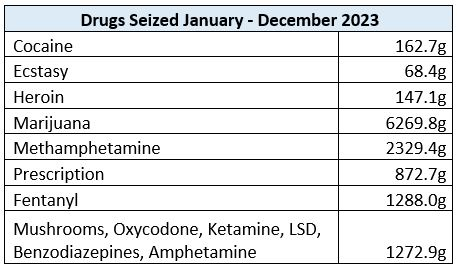

In [45]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://saccoprobation.saccounty.gov/Documents/Resources/Data/Drug%20Seizures/2023%20Drugs%20Seized.JPG"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [46]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [47]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=50, prompt_tokens=269, '
 'total_tokens=319, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [48]:
display(Markdown(gpt_result))

The issue with the image is that the last row combines multiple different drugs into one category, making it unclear and inconsistent with the rest of the table, which lists each drug separately. This could lead to confusion or misinterpretation of the data.

In [49]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=3112, prompt_tokens=238, '
 'total_tokens=3350, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=3008, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [50]:
display(Markdown(o1_result))

One obvious problem is that the table lumps together substances (including LSD) under a single total weight in grams. In particular, LSD is almost never tracked by the gram (it is typically measured in micrograms or individual doses), so showing “LSD” as part of a 1,272.9 g total is highly suspect. Additionally, it’s unusual to combine so many different substances into one “catch-all” row rather than listing their quantities separately.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  

Short Reflection

1. How the models reasoning supported your analysis
The model helped to establish relationships between drug types and drug quantities seized

2. Whether this approach could be applied to real-world intelligence workflows
Yes, this approach could be applied to a real-world intelligence workflow, especially in areas like crime analysis, border security, and drug enforcement

3. Any limitations or ethical concerns you encountered
The success of this approach heavily depends on the quality and completeness of the dataset. Missing or inaccurate data can skew the analysis and lead to wrong conclusions.